# Checkpoint 3

Implement here your algorithm to estimate the parametric field from timings recorded in the 20 electrodes of the mapping catheter.

The algorithm should output the following information:
- your estimates of parametric field


In [16]:
# imports

import numpy as np
import matplotlib.pyplot as plt

In [17]:
!git clone https://github.com/Alepescinaa/ScientificTools
%cd ScientificTools/Project1/Cp3

Cloning into 'ScientificTools'...
remote: Enumerating objects: 569, done.
remote: Counting objects: 100% (413/413), done.
remote: Compressing objects: 100% (329/329), done.
remote: Total 569 (delta 140), reused 226 (delta 68), pack-reused 156
Receiving objects: 100% (569/569), 136.79 MiB | 26.94 MiB/s, done.
Resolving deltas: 100% (178/178), done.
/content/ScientificTools/Project1/Cp3/ScientificTools/Project1/Cp3


In [18]:

# loading of the dataset

CP3data = np.load("CP3data.npz")
CP3data = CP3data['arr_0']

# Display one recording

In [19]:
ind_disp = 0
x_meas = CP3data[ind_disp][0]
y_meas = CP3data[ind_disp][1]
t_meas = CP3data[ind_disp][2]

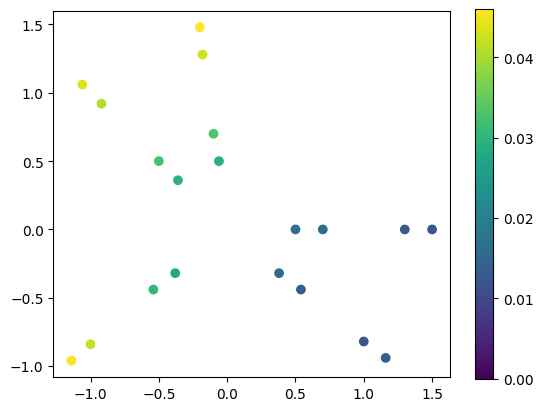

In [6]:
# Display a sample

plt.figure(1)
plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(t_meas) )
plt.gca().set_aspect(1)
plt.colorbar()

In [20]:
# loading of the estimate

CP3estimate = np.load("CP3field.npz")
CP3estimate = CP3estimate['arr_0']

In [21]:

speed_field = CP3estimate[ind_disp][0]

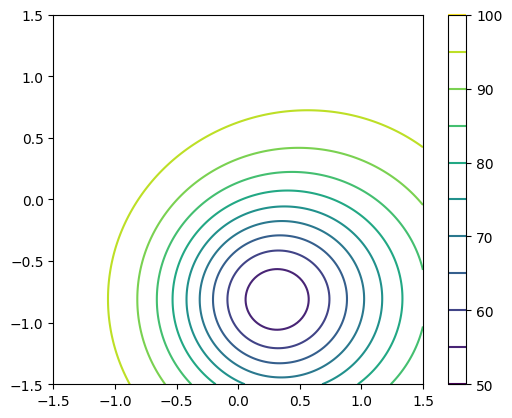

In [22]:
# Display a sample
X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))
plt.contour(X, Y, speed_field , 10)
plt.gca().set_aspect(1)
plt.colorbar()

In [10]:
index = np.zeros(100)

for i in range(100):
  speed_field = CP3estimate[i][0]

  count = np.sum(speed_field >= 98)
  if count > 0.75 * 151**2:
    index[i] = 1

In [10]:
np.where(index == 1)

(array([64, 87]),)

KERNEL PCA

In [ ]:
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler


mesh_size = 151 ** 2
num_samples = 100
A = np.zeros((mesh_size, num_samples))

for i in range(num_samples):
  A[:, i] = CP3estimate[i][0].flatten()

scaler = StandardScaler()
data_normalized = scaler.fit_transform(A)


kpca = KernelPCA(kernel='linear', n_components=3, fit_inverse_transform=True)
data_kpca = kpca.fit_transform(data_normalized)

data_rec=kpca.inverse_transform(data_kpca)
data_rec_scaled = scaler.inverse_transform(data_rec)


import matplotlib.pyplot as plt

# Plot the original speed field
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_field, cmap='viridis')
plt.title('Original Speed Field')
plt.colorbar()

# Plot the reconstructed data
plt.subplot(1, 2, 2)
plt.imshow(data_rec_scaled, cmap='viridis')
plt.title('Reconstructed Data')
plt.colorbar()

plt.tight_layout()
plt.show()



AUTOENCODER

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

latent_dim = 5

mesh_size = 151 ** 2
num_samples = 100
A = np.zeros((mesh_size, num_samples))

for i in range(num_samples):
  A[:, i] = CP3estimate[i][0].flatten()

scaler = StandardScaler()
data_normalized = scaler.fit_transform(A)

input_data = Input(shape=(mesh_size,))
encoded = Dense(latent_dim, activation=None)(input_data)
decoded = Dense(mesh_size, activation=None)(encoded)

# Create the autoencoder model
autoencoder = Model(input_data, decoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(data_normalized.T, data_normalized.T, epochs=500, batch_size=32)

# Extract the encoder part to get the latent representation
encoder = Model(input_data, encoded)


In [ ]:
latent_representations = encoder.predict(data_normalized.T)

reconstructed_A = autoencoder.predict(data_normalized.T)
reconstructed_A_rescaled = scaler.inverse_transform(reconstructed_A.T)

In [ ]:
latent_representations


In [ ]:

import matplotlib.pyplot as plt

# Plot the original speed field
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(A[:,10].reshape(151,151), cmap='viridis')
plt.title('Original Speed Field')
plt.colorbar()

# Plot the reconstructed data
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_A_rescaled[:,10].reshape(151,151), cmap='viridis')
plt.title('Reconstructed Data')
plt.colorbar()

plt.tight_layout()
plt.show()

SVD

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

mesh_size = 151**2
num_samples = 100
A = np.zeros((mesh_size, num_samples))

for i in range(num_samples):
  A[:, i] = CP3estimate[i][0].flatten()

#scaler = StandardScaler()
#A_normalized = scaler.fit_transform(A)


U, s, VT = np.linalg.svd(A, full_matrices=True)

fig, axes = plt.subplots(1, 3, figsize = (18,6))

axes[0].semilogy(s, 'o-')
axes[0].set_title('Singluar values')

axes[1].plot(np.cumsum(s)/np.sum(s), 'o-')
axes[1].set_title('Cumulate fraction of singular values')

axes[2].plot(np.cumsum(s**2)/np.sum(s**2), 'o-')
axes[2].set_title('Explained variance')

np.cumsum(s**2)/np.sum(s**2)

k=5
components=U@ np.diag(s)
A_rec = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow( CP3estimate[10][0])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Projected Image')
plt.imshow(A_rec[:, 10].reshape(151, 151))
plt.colorbar()



In [15]:
bases=components[:,k]
components.shape

(100, 22801)

In [13]:

import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

!pip -q install pyDOE
from pyDOE import lhs

# set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [14]:
# collocation points
Ncl = 151**2
Xcl = lhs(2,Ncl)
xcl = tf.expand_dims(tf.cast(-1.5+(3.0)*Xcl[:,0],dtype=tf.float64),axis=-1)
ycl = tf.expand_dims(tf.cast(-1.5+(3.0)*Xcl[:,1],dtype=tf.float64),axis=-1)
X_coll = tf.concat([xcl,ycl],1)

In [19]:
# PINN loss function
def loss(xcl,ycl,xmeas,ymeas,umeas,coeff):
    input_data=tf.concat([xmeas,ymeas],1)
    umeas_pred = PINN(input_data)
    r_pred   = r_PINN(xcl,ycl,coeff)

    # loss components
    mse_meas  = tf.reduce_mean(tf.pow(umeas-umeas_pred,2))
    mse_r  = tf.reduce_mean(tf.pow(r_pred,2))

    # bc
    y0 = tf.constant([-0.50784787],dtype=tf.float64)
    mse_bc= tf.pow( PINN( tf.transpose( tf.stack( [tf.constant([1.5],dtype=tf.float64), y0] ) ) ) ,2)


    return mse_meas + mse_r + mse_bc


# residual computation based on AD
@tf.function
def r_PINN(x,y,coeff):
    input_data=tf.concat([x,y],1)
    u = PINN(input_data)
    u_x = tf.gradients(u,x)[0]
    u_y = tf.gradients(u,y)[0]
    u_grad = tf.transpose(tf.concat([u_x, u_y], axis=1))

    pi = tf.constant(np.pi,dtype=tf.float64)
    theta_fiber = tf.constant([0.11629039] ,dtype=tf.float64)
    a_ratio = tf.constant([5.26792418], dtype=tf.float64)
    theta0 = pi/2 - theta_fiber
    a = tf.stack([tf.cos(theta0), tf.sin(theta0)])
    b = tf.stack([tf.cos(theta0-pi/2), tf.sin(theta0-pi/2)])

    D_00 = 1 / a_ratio * a[0]**2 + b[0]**2
    D_01 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_10 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_11 = 1 / a_ratio * a[1]**2 + b[1]**2



    return (bases@coeff)*tf.sqrt(((u_x * D_00 * u_x + u_x * D_01 * u_y + u_y * D_10 * u_x + u_y * D_11 * u_y)))  - 1


# neural network weight gradients
@tf.function
def grad(model,xcl,ycl,xmeas,ymeas,umeas,coeff):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,ycl,xmeas,ymeas,umeas,coeff)
        grads = tape.gradient(loss_value,model.trainable_variables)
        grads_weight= tape.gradient(loss_value,coeff)
    return loss_value, grads, grads_weight

In [16]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM


regularization_strength = 1e-3

PINN = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,),
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    #tf.keras.layers.BatchNormalization(),

    #tf.keras.layers.Reshape((1, 64)),

    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 64)),

    tf.keras.layers.Dense(128, activation='relu',
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(32, activation='relu',
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1, activation=None,
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64)
])


In [ ]:
#selected values  [0.10337211, 4.95760936, -0.50074575]  [0.12920869, 5.57823901, -0.51495002]
print((0.10337211+0.12920869)/2, ( 4.95760936+5.57823901)/2, (-0.50074575+-0.5149500)/2)

In [20]:
def checkpoint2_solution( x, y , t ):

  xmeas_train, xmeas_val, ymeas_train, ymeas_val, tmeas_train, tmeas_val = train_test_split(x, y, t, test_size=0.05)
  xmeas_train = tf.constant(xmeas_train.reshape(19, 1), dtype=tf.float64)
  ymeas_train = tf.constant(ymeas_train.reshape(19, 1), dtype=tf.float64)
  tmeas_train = tf.constant(tmeas_train.reshape(19, 1), dtype=tf.float64)
  xmeas_val = tf.constant(xmeas_val.reshape(1, 1), dtype=tf.float64)
  ymeas_val = tf.constant(ymeas_val.reshape(1, 1), dtype=tf.float64)
  tmeas_val = tf.constant(tmeas_val.reshape(1, 1), dtype=tf.float64)

  X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))


  coeff=tf.Variable([[100],[100],[100],[100],[100]], trainable=True,dtype=tf.float64)


  pinn_optimizer = tf.keras.optimizers.Adam(learning_rate=0.005,beta_1=0.99)
  pinn_optimizer.build(PINN.trainable_variables)

  coeff_optimizer = tf.keras.optimizers.Adam(learning_rate=0.005,beta_1=0.99)
  coeff_optimizer.build([coeff])


  """
  patience = float('inf')
  patience_lr= float('inf')
  min_delta = 1e-9
  best_val_loss = float('inf')
  wait = 0
  count = 0
  """

  print()
  for iter in range(4000):

    loss_value,grads,grads_weight = grad(PINN,xcl,ycl,xmeas_train, ymeas_train, tmeas_train,coeff)

    pinn_optimizer.apply_gradients(zip(grads,PINN.trainable_variables))
    coeff_optimizer.apply_gradients(zip(grads_weight,[coeff]))

    loss_value_val, _, _ = grad(PINN, xcl, ycl, xmeas_val, ymeas_val, tmeas_val,coeff)

    """
    best_weigths = None
    best_params = None

    # Early stopping
    if loss_value_val < best_val_loss - min_delta:
        best_val_loss = loss_value_val
        wait = 0
        count = 0
        best_weights = PINN.get_weights()
        best_params = theta_fiber.numpy()
    else:
        wait += 1
        count += 1

        if count >= patience_lr:
          tf_optimizer.learning_rate = tf_optimizer.learning_rate * 0.9
          count = 0

        if wait >= patience:
            print('Early stopping at epoch', iter + 1)
            break
    """


    if ((iter+1) % 100 == 0):
      print('iter =  '+str(iter+1))
      tf.print('loss =' , loss_value)
      tf.print('loss_val_param =' , loss_value_val)

      print(coeff.numpy())
      print()

  return coeff

In [21]:
weights = checkpoint2_solution(x_meas, y_meas , t_meas)


iter =  100
loss = [[1.0711433926839455]]
loss_val_param = [[1.0783635627681507]]
[[99.62974444]
 [99.62974444]
 [99.62974444]
 [99.62974444]
 [99.62974444]]

iter =  200
loss = [[1.0175793838133973]]
loss_val_param = [[1.0182696476947961]]
[[99.42135819]
 [99.42135819]
 [99.42135819]
 [99.42135819]
 [99.42135819]]

iter =  300
loss = [[1.0073444872760371]]
loss_val_param = [[1.0070097244637419]]
[[99.31093992]
 [99.31093992]
 [99.31093992]
 [99.31093992]
 [99.31093992]]

iter =  400
loss = [[1.0030676944012511]]
loss_val_param = [[1.0023265822234357]]
[[99.25384717]
 [99.25384717]
 [99.25384717]
 [99.25384717]
 [99.25384717]]

iter =  500
loss = [[1.0011793879349131]]
loss_val_param = [[1.0008676906776925]]
[[99.22638105]
 [99.22638105]
 [99.22638105]
 [99.22638105]
 [99.22638105]]

iter =  600
loss = [[1.0008987802383953]]
loss_val_param = [[1.0006542291206133]]
[[99.21354019]
 [99.21354019]
 [99.21354019]
 [99.21354019]
 [99.21354019]]

iter =  700
loss = [[1.000840590788755]]
loss

KeyboardInterrupt: 

In [ ]:
vel_map=bases@coeff

# Function

Implemenatation of the algorithm presented in :

Sermesant, Maxime, et al. "An anisotropic multi-front fast marching method for real-time simulation of cardiac electrophysiology." Functional Imaging and Modeling of the Heart: 4th International Conference, FIHM 2007, Salt Lake City, UT, USA, June 7-9, 2007. Proceedings 4. Springer Berlin Heidelberg, 2007.

In [ ]:
def anysotropic_FMM( x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22, speed_field ):



    (j,i)= ( (np.abs(X-x0)).argmin(1)[0] , (np.abs(Y-y0)).argmin(0)[0]  )
    #print( i,j )
    #print(x0,y0)
    #print(X[i,j], Y[i,j])
    #print()

    T = (10^4)*(np.ones(np.shape(X)))
    T[i,j] = 0

    T_final = (10^4)*(np.ones(np.shape(X)))
    T_final[i,j] = 0

    TRIAL = [ (i,j) ]
    KNOWN = []
    KNOWN_C = []
    CHANGED = []

    KNOWN_MAT = (np.zeros(np.shape(X)))
    CHANGED_MAT = (np.zeros(np.shape(X)))


    def update_fun( T_xi,T_x,T_y, X_xi, X_x, X_y, Y_xi, Y_x, Y_y, flag_known, speed_val):

        if ( flag_known ):
            triangle_list = [ p*T_x+(1-p)*T_y + np.sqrt( sigma_11*( p*(X_xi-X_x) + (1-p)*(X_xi-X_y) )**2 + 2*sigma_12*( p*(X_xi-X_x) + (1-p)*(X_xi-X_y) )*( p*(Y_xi-Y_x) + (1-p)*(Y_xi-Y_y) ) + sigma_22*( p*(Y_xi-Y_x) + (1-p)*(Y_xi-Y_y) )**2 )/speed_val for p in np.arange(0,1.1,0.1)]
            T_xi = np.min( [ T_xi , np.min(triangle_list) ] )
        else:
            T_xi = np.min( [ T_xi , T_x + np.sqrt( sigma_11*( (X_xi-X_x) )**2 + 2*sigma_12*( (X_xi-X_x) )*( Y_xi-Y_x ) + sigma_22*( Y_xi-Y_x )**2 )/speed_val ] )

        return T_xi

    while (np.shape(TRIAL)[0]>0) | (np.shape(CHANGED)[0]>0):

        if (np.shape(CHANGED)[0]==0):
            ind_sel =  ( np.array([T_final[i,j] for (i,j) in TRIAL]) ).argmin()
            (i_sel,j_sel) = TRIAL[ind_sel]
            # add X to known
            KNOWN.append( TRIAL[ind_sel] )
            KNOWN_MAT[i_sel,j_sel] = 1
            # remove X from trial
            del TRIAL[ind_sel]
        else:
            ind_sel =  ( np.array([T_final[i,j] for (i,j) in CHANGED]) ).argmin()
            (i_sel,j_sel) = CHANGED[ind_sel]
            CHANGED_MAT[i_sel,j_sel] = 0
            # remove X from changed
            del CHANGED[ind_sel]

        T_X = T[i_sel,j_sel]

        # UPDATE 1

        if (i_sel!=0):

            #if ((i_sel-1,j_sel) in KNOWN ):
            if (KNOWN_MAT[i_sel-1,j_sel] == 1 ):

                #T[i_sel-1,j_sel] = 10^4

                if (j_sel!=150):

                    T[i_sel-1,j_sel] = update_fun(T_xi = T[i_sel-1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel+1],
                                                X_xi = X[i_sel-1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel+1],
                                                    Y_xi= Y[i_sel-1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel+1] == 1 ),
                                                    speed_val = speed_field[i_sel-1,j_sel] )


                if (j_sel!=0):
                    #if ((i_sel-1,j_sel-1) in KNOWN ):

                    T[i_sel-1,j_sel] = update_fun(T_xi = T[i_sel-1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel-1],
                                                X_xi = X[i_sel-1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel-1],
                                                    Y_xi= Y[i_sel-1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel-1] == 1 ),
                                                    speed_val = speed_field[i_sel-1,j_sel]  )


                # if ((i_sel-1,j_sel) not in TRIAL ):
                #     TRIAL.append( (i_sel-1,j_sel) )
                if ( CHANGED_MAT[i_sel-1,j_sel] != 1 ):
                    if ( T[i_sel-1,j_sel] < T_final[i_sel-1,j_sel] ):
                        T_final[i_sel-1,j_sel] = T[i_sel-1,j_sel]
                        CHANGED.append( (i_sel-1,j_sel) )
                        CHANGED_MAT[i_sel-1,j_sel] = 1

        if (j_sel!=0):
            #if ((i_sel,j_sel-1) in KNOWN ):
            if (KNOWN_MAT[i_sel,j_sel-1] == 1 ):

                #T[i_sel,j_sel-1] = 10^4


                if (i_sel!=150):
                    #if ((i_sel+1,j_sel-1) in KNOWN ):

                    T[i_sel,j_sel-1] = update_fun(T_xi = T[i_sel,j_sel-1],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel-1],
                                                X_xi = X[i_sel,j_sel-1], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel-1],
                                                    Y_xi= Y[i_sel,j_sel-1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel-1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel-1] )


                if (i_sel!=0):
                    #if ((i_sel-1,j_sel-1) in KNOWN ):

                    T[i_sel,j_sel-1] = update_fun(T_xi = T[i_sel,j_sel-1],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel-1],
                                                X_xi = X[i_sel,j_sel-1], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel-1],
                                                    Y_xi= Y[i_sel,j_sel-1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel-1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel-1] )

                #if ((i_sel,j_sel-1) not in TRIAL ):
                #    TRIAL.append( (i_sel,j_sel-1) )
                if ( CHANGED_MAT[i_sel,j_sel-1] != 1 ):
                    if ( T[i_sel,j_sel-1] < T_final[i_sel,j_sel-1] ):
                        T_final[i_sel,j_sel-1] = T[i_sel,j_sel-1]
                        CHANGED.append( (i_sel,j_sel-1) )
                        CHANGED_MAT[i_sel,j_sel-1] = 1
                    #T[i_sel,j_sel-1] = T[i_sel,j_sel] + np.sqrt( ( X[i_sel,j_sel-1]-X[i_sel,j_sel] )**2 + ( Y[i_sel,j_sel-1]-Y[i_sel,j_sel] )**2 )/100

        if (i_sel!=150):
            #if ((i_sel+1,j_sel) in KNOWN ):
            if (KNOWN_MAT[i_sel+1,j_sel] == 1 ):

                #T[i_sel+1,j_sel] = 10^4

                if (j_sel!=150):
                    #if ((i_sel+1,j_sel+1) in KNOWN ):

                    T[i_sel+1,j_sel] = update_fun(T_xi = T[i_sel+1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel+1],
                                                X_xi = X[i_sel+1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel+1],
                                                    Y_xi= Y[i_sel+1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel+1,j_sel] )

                if (j_sel!=0) :
                    #if ((i_sel+1,j_sel-1) in KNOWN ):

                    T[i_sel+1,j_sel] = update_fun(T_xi = T[i_sel+1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel-1],
                                                X_xi = X[i_sel+1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel-1],
                                                    Y_xi= Y[i_sel+1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel-1] == 1 ) ,
                                                    speed_val = speed_field[i_sel+1,j_sel] )

                # if ((i_sel+1,j_sel) not in TRIAL ):
                #     TRIAL.append( (i_sel+1,j_sel) )
                if ( CHANGED_MAT[i_sel+1,j_sel] != 1 ):
                    if ( T[i_sel+1,j_sel] < T_final[i_sel+1,j_sel] ):
                        T_final[i_sel+1,j_sel] = T[i_sel+1,j_sel]
                        CHANGED.append( (i_sel+1,j_sel) )
                        CHANGED_MAT[i_sel+1,j_sel] = 1

        if (j_sel!=150):
            #if ((i_sel,j_sel+1) in KNOWN ):
            if (KNOWN_MAT[i_sel,j_sel+1] == 1 ):

                #T[i_sel,j_sel+1] = 10^4

                if (i_sel!=150):
                    #if ((i_sel+1,j_sel+1) in KNOWN ):
                    T[i_sel,j_sel+1] = update_fun(T_xi = T[i_sel,j_sel+1],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel+1],
                                                X_xi = X[i_sel,j_sel+1], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel+1],
                                                    Y_xi= Y[i_sel,j_sel+1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel+1] )

                if (i_sel!=0):
                    #if ((i_sel-1,j_sel+1) in KNOWN ):

                    T[i_sel,j_sel+1] = update_fun(T_xi = T[i_sel,j_sel+1],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel+1],
                                                X_xi = X[i_sel,j_sel+1], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel+1],
                                                    Y_xi= Y[i_sel,j_sel+1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel+1] )


                # if ((i_sel,j_sel+1) not in TRIAL ):
                #     TRIAL.append( (i_sel,j_sel+1) )
                if ( CHANGED_MAT[i_sel,j_sel+1] != 1 ):
                    if ( T[i_sel,j_sel+1] < T_final[i_sel,j_sel+1] ):
                        T_final[i_sel,j_sel+1] = T[i_sel,j_sel+1]
                        CHANGED.append( (i_sel,j_sel+1) )
                        CHANGED_MAT[i_sel,j_sel+1] = 1

        # UPDATE 2

        if (i_sel!=0):

            #if ((i_sel-1,j_sel) not in KNOWN ) :
            if (KNOWN_MAT[i_sel-1,j_sel] != 1 ):

                T[i_sel-1,j_sel] = 10^4

                if (j_sel!=150):
                    #if ((i_sel-1,j_sel+1) in KNOWN ):

                    T[i_sel-1,j_sel] = update_fun(T_xi = T[i_sel-1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel+1],
                                                X_xi = X[i_sel-1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel+1],
                                                    Y_xi= Y[i_sel-1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel+1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel-1,j_sel] )

                if (j_sel!=0):
                    #if ((i_sel-1,j_sel-1) in KNOWN ):

                    T[i_sel-1,j_sel] = update_fun(T_xi = T[i_sel-1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel-1],
                                                X_xi = X[i_sel-1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel-1],
                                                    Y_xi= Y[i_sel-1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel-1] == 1 ) ,
                                                    speed_val = speed_field[i_sel-1,j_sel] )

                if ((i_sel-1,j_sel) in TRIAL ):
                    if ( T[i_sel-1,j_sel] < T_final[i_sel-1,j_sel] ):
                        T_final[i_sel-1,j_sel] = T[i_sel-1,j_sel]
                else: # ((i_sel-1,j_sel) not in KNOWN ):
                    if ( T[i_sel-1,j_sel] < T_final[i_sel-1,j_sel] ):
                        T_final[i_sel-1,j_sel] = T[i_sel-1,j_sel]
                    #KNOWN_C.append( (i_sel-1,j_sel) )
                    TRIAL.append( (i_sel-1,j_sel) )

        if (j_sel!=0):
            #if ((i_sel,j_sel-1) not in KNOWN ) :
            if (KNOWN_MAT[i_sel,j_sel-1] != 1 ):

                T[i_sel,j_sel-1] = 10^4


                if (i_sel!=150):
                    #if ((i_sel+1,j_sel-1) in KNOWN ):

                    T[i_sel,j_sel-1] = update_fun(T_xi = T[i_sel,j_sel-1],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel-1],
                                                X_xi = X[i_sel,j_sel-1], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel-1],
                                                    Y_xi= Y[i_sel,j_sel-1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel+1,j_sel-1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel-1] )

                if (i_sel!=0):
                    #if ((i_sel-1,j_sel-1) in KNOWN ):

                    T[i_sel,j_sel-1] = update_fun(T_xi = T[i_sel,j_sel-1],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel-1],
                                                X_xi = X[i_sel,j_sel-1], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel-1],
                                                    Y_xi= Y[i_sel,j_sel-1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel-1],
                                                    flag_known =  (KNOWN_MAT[i_sel-1,j_sel-1] == 1 ),
                                                    speed_val = speed_field[i_sel,j_sel-1]  )


                if ((i_sel,j_sel-1) in TRIAL ):
                    if ( T[i_sel,j_sel-1] < T_final[i_sel,j_sel-1] ):
                        T_final[i_sel,j_sel-1] = T[i_sel,j_sel-1]
                else : # ((i_sel,j_sel-1) not in KNOWN ):
                    if ( T[i_sel,j_sel-1] < T_final[i_sel,j_sel-1] ):
                        T_final[i_sel,j_sel-1] = T[i_sel,j_sel-1]
                    #KNOWN_C.append( (i_sel,j_sel-1) )
                    TRIAL.append( (i_sel,j_sel-1) )
                #T[i_sel,j_sel-1] = T[i_sel,j_sel] + np.sqrt( ( X[i_sel,j_sel-1]-X[i_sel,j_sel] )**2 + ( Y[i_sel,j_sel-1]-Y[i_sel,j_sel] )**2 )/100

        if (i_sel!=150):
            #if ((i_sel+1,j_sel) not in KNOWN ) :
            if (KNOWN_MAT[i_sel+1,j_sel] != 1 ):

                T[i_sel+1,j_sel] = 10^4

                if (j_sel!=150):
                    #if ((i_sel+1,j_sel+1) in KNOWN ):

                    T[i_sel+1,j_sel] = update_fun(T_xi = T[i_sel+1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel+1],
                                                X_xi = X[i_sel+1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel+1],
                                                    Y_xi= Y[i_sel+1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel+1],
                                                    flag_known = (KNOWN_MAT[i_sel+1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel+1,j_sel] )

                if (j_sel!=0) :
                    #if ((i_sel+1,j_sel-1) in KNOWN ):

                    T[i_sel+1,j_sel] = update_fun(T_xi = T[i_sel+1,j_sel],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel-1],
                                                X_xi = X[i_sel+1,j_sel], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel-1],
                                                    Y_xi= Y[i_sel+1,j_sel], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel-1],
                                                    flag_known = (KNOWN_MAT[i_sel+1,j_sel-1] == 1 ),
                                                    speed_val = speed_field[i_sel+1,j_sel]  )


                if ((i_sel+1,j_sel) in TRIAL ):
                    if ( T[i_sel+1,j_sel] < T_final[i_sel+1,j_sel] ):
                        T_final[i_sel+1,j_sel] = T[i_sel+1,j_sel]
                else: #if ((i_sel+1,j_sel) not in KNOWN ):
                    if ( T[i_sel+1,j_sel] < T_final[i_sel+1,j_sel] ):
                        T_final[i_sel+1,j_sel] = T[i_sel+1,j_sel]
                    #KNOWN_C.append( (i_sel+1,j_sel) )
                    TRIAL.append( (i_sel+1,j_sel) )

        if (j_sel!=150):
            #if ((i_sel,j_sel+1) not in KNOWN ) :
            if (KNOWN_MAT[i_sel,j_sel+1] != 1 ):

                T[i_sel,j_sel+1] = 10^4

                if (i_sel!=150):
                    #if ((i_sel+1,j_sel+1) in KNOWN ):

                    T[i_sel,j_sel+1] = update_fun(T_xi = T[i_sel,j_sel+1],T_x = T[i_sel,j_sel],T_y = T[i_sel+1,j_sel+1],
                                                X_xi = X[i_sel,j_sel+1], X_x= X[i_sel,j_sel], X_y= X[i_sel+1,j_sel+1],
                                                    Y_xi= Y[i_sel,j_sel+1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel+1,j_sel+1],
                                                    flag_known = (KNOWN_MAT[i_sel+1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel+1] )

                if (i_sel!=0):
                    #if ((i_sel-1,j_sel+1) in KNOWN ):

                    T[i_sel,j_sel+1] = update_fun(T_xi = T[i_sel,j_sel+1],T_x = T[i_sel,j_sel],T_y = T[i_sel-1,j_sel+1],
                                                X_xi = X[i_sel,j_sel+1], X_x= X[i_sel,j_sel], X_y= X[i_sel-1,j_sel+1],
                                                    Y_xi= Y[i_sel,j_sel+1], Y_x=Y[i_sel,j_sel], Y_y=Y[i_sel-1,j_sel+1],
                                                    flag_known = (KNOWN_MAT[i_sel-1,j_sel+1] == 1 ) ,
                                                    speed_val = speed_field[i_sel,j_sel+1]  )


                if ((i_sel,j_sel+1) in TRIAL ):
                    if ( T[i_sel,j_sel+1] < T_final[i_sel,j_sel+1] ):
                        T_final[i_sel,j_sel+1] = T[i_sel,j_sel+1]
                else: #if ((i_sel,j_sel+1) not in KNOWN ):
                    if ( T[i_sel,j_sel+1] < T_final[i_sel,j_sel+1] ):
                        T_final[i_sel,j_sel+1] = T[i_sel,j_sel+1]
                    #KNOWN_C.append( (i_sel,j_sel+1) )
                    TRIAL.append( (i_sel,j_sel+1) )

    return T_final

# Physics based model

Let us consider the Eikonal model: given the parametric field c(x,y), find T(x,y)

\begin{aligned}
  & c(x,y) \sqrt{ \nabla T(x,y) D \nabla T(x,y)} = 1  \,, \quad (x,y) \in [-1.5,1.5] \times [-1.5,1.5]\,,\\
  & u(x,y) = 0  \,, \qquad \qquad \qquad \qquad \qquad x=x_0,y=y_0 \,, \\
\end{aligned}

where
\begin{aligned}
D = 1\ \vec{b} \otimes \vec{b} + \frac{1}{a_{ratio}}  \ \vec{a} \otimes \vec{a},
\end{aligned}
being $ \vec{b} = \vec{b}(\theta) $ the fiber orientation and $ \vec{a} = \vec{a}(\theta) $ the cross-fiber orientation (orthogonal to $ \vec{b}$).

The following parameters are unknown, but they take the same value for all samples:
- the fiber angle $\theta$,
- anisotropy ratio $a_{ratio}$,
- the starting point position $y_0$.

In [ ]:
X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))

x0 = 1.5
y0 = 0
theta_fiber = 0
a_ratio = 2

theta0 = np.pi/2 - theta_fiber
a = np.array([np.cos(theta0), np.sin(theta0)]).T
b = np.array([np.cos(theta0-np.pi/2), np.sin(theta0-np.pi/2)]).T

D = ( (1/a_ratio)*np.tensordot( a, a,  axes=0) + np.tensordot( b, b,  axes=0)  )
print(D)

D_inv = np.linalg.inv(D)
sigma_11 = D_inv[0][0]
sigma_12 = D_inv[0][1]
sigma_21 = D_inv[1][0]
sigma_22 = D_inv[1][1]

activation_time = anysotropic_FMM( x0 , y0 , X, Y, sigma_11,sigma_12, sigma_21, sigma_22, speed_field )



In [ ]:


plt.contour(X, Y, activation_time , 10)
#plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(activation_time) )
plt.gca().set_aspect(1)
plt.colorbar()

# signature of the function

def checkpoint3_solution( x, y , t ):

return speed_field



In [ ]:

def checkpoint3_solution( x, y , t ):

    speed_field = 0

    return speed_field

speed_field = checkpoint2_solution( x_meas, y_meas , t_meas )